In [1]:
import numpy as np
import matplotlib.pyplot as pl
from collections import defaultdict
import utm
import vg

np.set_printoptions(formatter={'float_kind':'{:.3f}'.format})
pl.style.use('seaborn-whitegrid')

## Methodology

I ran the Caucusus F/A-18 "weapons practice" instant action mission, with the unlimited weapons difficulty option enabled and Tacview set to record. While airborne, I set the aircraft in a level attitude and enabled active pause.

I fired the cannon in 10 consecutive trigger pulls, each time emptying all 578 cannon rounds. That created a data set of 5780 projectiles.

I used the code below to scrape the projectile data from tacview. I use Python's `utm` package to convert from lat/lon into MGRS, which is useful because it has Cartesian coordinates measured in meters. Finally I translate all the bullet trajectories so that they start at $(x,y, z) = (0, 0, 0)$ (but I leave the timestamp alone).

In [4]:
def lat_lon_to_utm(lat, lon):
    x, y, zone, ut = utm.from_latlon(lat+37, lon+37)
    return x, y
    
def bullet_to_utm(trajectory):
    def convert(ll_entry):
        t, lat, lon, alt = ll_entry
        x, y = lat_lon_to_utm(lat, lon)
        return t, x, y, alt
    coords = np.array([convert(ll_entry) for ll_entry in trajectory])
    # recenter so that the point of origin is 0, 0 in x/y but leave time alone
    coords[:, 1:] = coords[:,1:] - coords[0,1:]
    return coords

def convert_trajectories_to_utm(trajectories):
    return [bullet_to_utm(traj) for traj in trajectories]

def parse_bullet_info(f):
    results = defaultdict(list)
    found_first_entry = False
    current_time = 0
    while True:
        line = f.readline()
        if not line:
            return [np.array(results[r]) for r in results]
        if not found_first_entry:
            # skip every line until we find the first timestamp
            if line.startswith('#'):
                current_time = float(line[1:])
                found_first_entry = True
        else:
            if line.startswith('#'):
                current_time = float(line[1:])
                #print(f"time is now {current_time}")
            else:
                fields = line.split(',')
                obj_id = int(fields[0], 16)
                already_tracked = obj_id in results.keys()
                is_a_new_bullet = any(field.startswith('Type=Projectile+Shell') for field in fields)
                if already_tracked or is_a_new_bullet:
                    posit = fields[1][2:]
                    posit = posit.split('|')
                    #print(posit)
                    try:
                        lat, lon, alt = (float(val) for val in posit)
                        results[obj_id].append([current_time, lat, lon, alt])
                    except ValueError:
                        pass
                    

def analyze_dispersion(trajectories):
    initials = np.array([r[1,1:] for r in trajectories])
    avg = np.mean(initials, axis=0)
    phi = np.arctan(avg[1]/avg[0])
    rotated = vg.rotate(initials, np.array([0,0,1]), -phi, units='rad')
    avg_rotated = vg.rotate(avg, np.array([0,0,1]), -phi, units='rad')
    theta = np.arctan2(avg_rotated[2], avg_rotated[0])
    avg_rotated2 = vg.rotate(avg_rotated, np.array([0,1,0]), theta, units='rad')
    rotated2 = vg.rotate(rotated, np.array([0, 1, 0]), vg.angle(avg_rotated, np.array([1, 0, 0])))

    yz = rotated2.T[1:3]

    dist = avg_rotated2[0]
    
    return yz

def parse_file(filename):
    with open(filename, 'r') as f:
        return parse_bullet_info(f)

acmi_old = 'Tacview-20200529-111058-DCS-Caucasus FA-18C Weapon Practice.txt.acmi'
acmi_new = 'Tacview-20200603-190922-DCS-Caucasus FA-18C Weapon Practice.txt.acmi'

results = convert_trajectories_to_utm(parse_file(acmi_old))
old_dispersion = analyze_dispersion(results)
new_dispersion = analyze_dispersion(convert_trajectories_to_utm(parse_file(acmi_new)))
    


In [5]:
old_dispersion - new_dispersion

array([[-1.865, 1.183, 1.747, ..., -1.227, -0.737, -0.955],
       [-0.451, -1.433, -1.430, ..., 5.941, -1.082, 1.821]])

The data containenew_dispersionesults` is 5780 series of $(t, x, y, z)$. Below is the altitude of the 6th bullet fired vs. range, as well as its trajectory.

Tacview appears to sample projectile positions at 2 Hz. The initial angle of the bullet is shown by the red line. (Note: **none of the 3d plots are shown to scale**)

Text(0.5, 0, 'y')

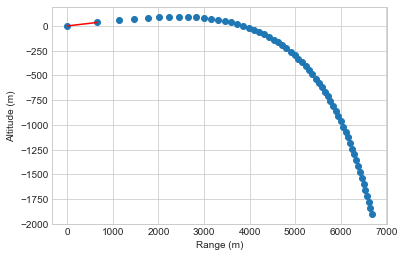

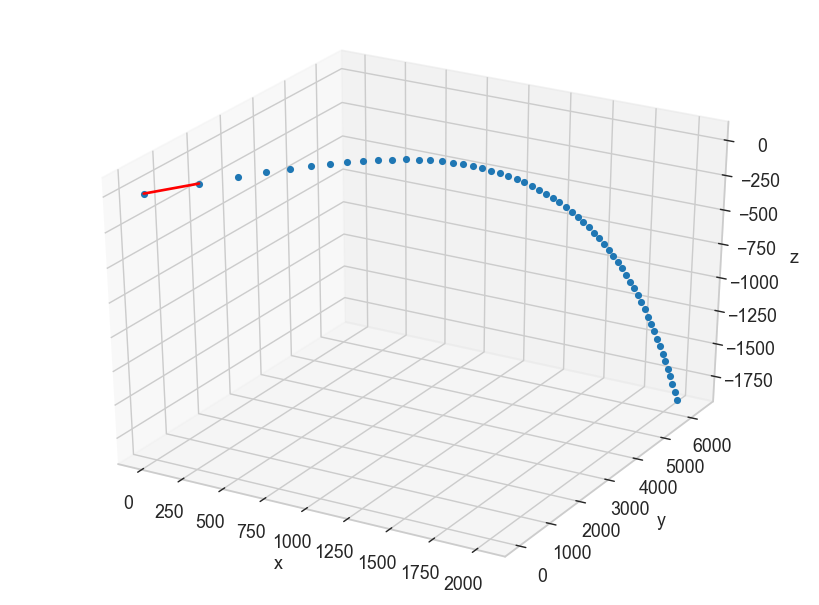

In [6]:
t, x, y, z = results[5].T

pl.figure()
pl.plot(np.sqrt(x*x+y*y), z, 'o')
pl.plot(np.sqrt(x[:2]*x[:2]+y[:2]*y[:2]), z[:2], color='red')
#pl.plot(y, z)
pl.grid(True)
pl.xlabel('Range (m)')
pl.ylabel('Altitude (m)')
#pl.ylim(0, 2300)

fig = pl.figure(dpi=128, figsize=[8,6])
fig.add_subplot(111, projection='3d')
pl.plot(x, y, z, '.')
pl.plot(x[:2], y[:2], z[:2], color='red')
pl.gca().set_zlabel('z')
pl.xlabel('x')
pl.ylabel('y')

In the `initials` array, I save only the projectile position in after its second data point (second endpoint of the red line above), and discard time information. I do this for each of the 5780 rounds fired.

In [7]:
initials = np.array([r[1,1:] for r in results])
initials.shape

(5780, 3)

I find the mean of all shots fired (center of impact). I rotate all shots to be aligned along this axis.

In [8]:
avg = np.mean(initials, axis=0)
fig = pl.figure(dpi=128, figsize=[8,6])
fig.set_as
fig.add_subplot(111, projection='3d')
pl.plot([0, avg[0]], [0, avg[1]], [0, avg[2]], lw=3, color='black')

for v in initials[:50]:
    pl.plot([0, v[0]], [0, v[1]], [0, v[2]], lw=.2, ls='--', color='orange', label='first 50 shots')
pl.xlabel('x')
pl.ylabel('y')
pl.gca().set_zlabel('z')
pl.legend(('avg of all shots', 'first 50 shots'));

AttributeError: 'Figure' object has no attribute 'set_as'

<Figure size 1024x768 with 0 Axes>

The angle $\varphi$ is the angle in the $xy$ (horizontal) plane. After this, `rotated` refers to all vectors centered around the y-axis. Applying the same rotation to `avg`, we see that `avg_rotated`'s $y$ component is effectively 0.

Avg_rotated is [668.950 0.000 36.415]


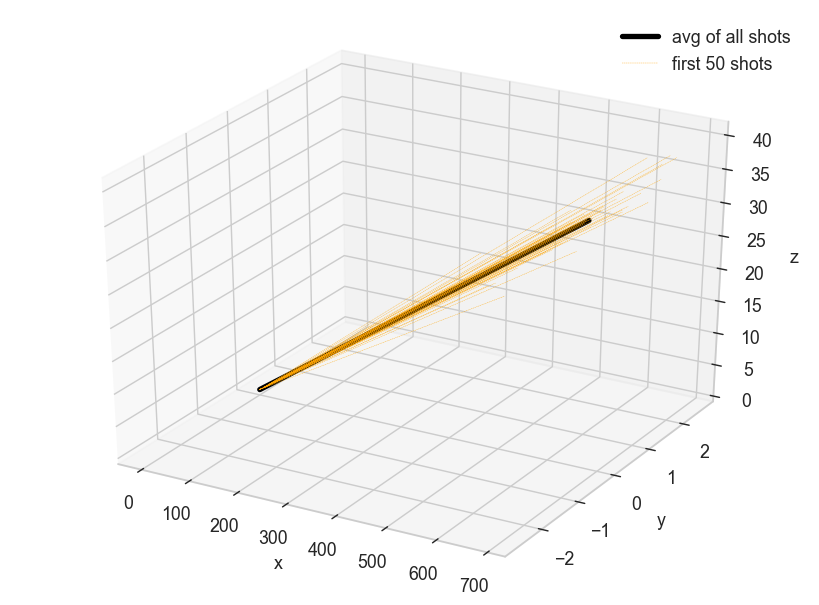

In [9]:
phi = np.arctan(avg[1]/avg[0])
rotated = vg.rotate(initials, np.array([0,0,1]), -phi, units='rad')
avg_rotated = vg.rotate(avg, np.array([0,0,1]), -phi, units='rad')

print("Avg_rotated is {}".format(avg_rotated))

fig = pl.figure(dpi=128, figsize=[8,6])
fig.add_subplot(111, projection='3d')
pl.plot([0, avg_rotated[0]], [0, avg_rotated[1]], [0, avg_rotated[2]], lw=3, color='black')
for v in rotated[:50]:
    pl.plot([0, v[0]], [0, v[1]], [0, v[2]], lw=.2, ls='--', color='orange')
pl.xlabel('x')
pl.ylabel('y')
pl.gca().set_zlabel('z')
pl.legend(('avg of all shots', 'first 50 shots'));

Then I find the angle $\theta$ which is the angle above the horizontal plane, and apply the same transformation to the collection of vectors so that the center of impact is within the horizontal plane. You can see that the vectors are now centered around the $x$-axis.

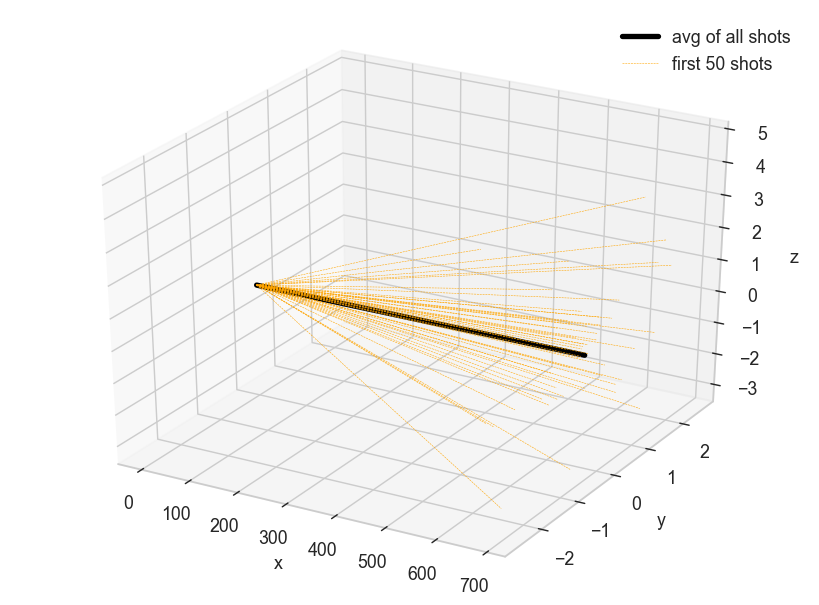

In [10]:
theta = np.arctan2(avg_rotated[2], avg_rotated[0])
avg_rotated2 = vg.rotate(avg_rotated, np.array([0,1,0]), theta, units='rad')

rotated2 = vg.rotate(rotated, np.array([0, 1, 0]), vg.angle(avg_rotated, np.array([1, 0, 0])))

fig = pl.figure(dpi=128, figsize=[8,6])
fig.add_subplot(111, projection='3d')
pl.plot([0, avg_rotated2[0]], [0, avg_rotated2[1]], [0, avg_rotated2[2]], lw=3, color='black')
for v in rotated2[:50]:
    pl.plot([0, v[0]], [0, v[1]], [0, v[2]], lw=.3, ls='--', color='orange')
pl.xlabel('x')
pl.ylabel('y')
pl.gca().set_zlabel('z')
pl.legend(('avg of all shots', 'first 50 shots'));

Here is the $yz$ plane of the plot show n above, with 8mil and 12mil diameter circles plotted.

1


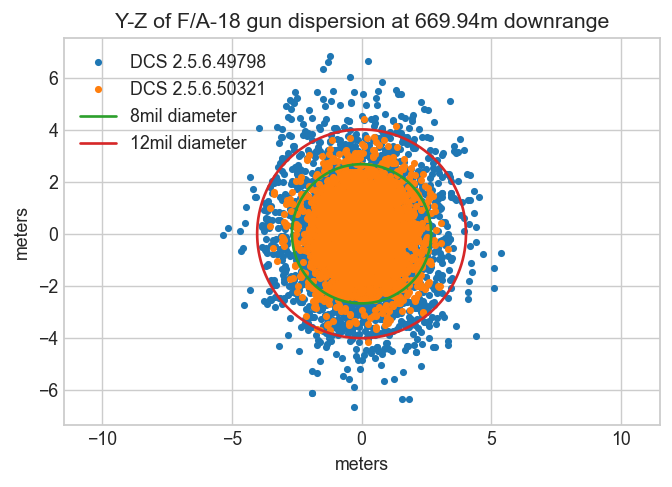

In [22]:
pl.figure(dpi=128)
pl.axis('equal')
yz = old_dispersion
yz_new = new_dispersion

dist = avg_rotated2[0]

rng = vg.magnitude(avg)
print(len(np.where(vg.magnitude(yz.T) < .004*dist)))
pl.plot(yz[0], yz[1], '.', label='DCS 2.5.6.49798')
pl.plot(yz_new[0], yz_new[1], '.', label='DCS 2.5.6.50321')
pl.savefig('positions.png')
size = vg.magnitude(avg)
angle_8mil = .004 * vg.magnitude(avg)
circ = np.exp(np.linspace(0, 2*np.pi, 2048)*1j)*angle_8mil
pl.plot(circ.real, circ.imag, label='8mil diameter')
pl.plot(circ.real*.006/.004, circ.imag*.006/.004, label='12mil diameter')
pl.title(f"Y-Z of F/A-18 gun dispersion at {rng:.2f}m downrange")
pl.ylabel('meters')
pl.xlabel('meters')
pl.legend()
pl.savefig('positions.png')



In [17]:
len(new_dispersion.)

2

In [12]:
new_dispersion - old_dispersion

array([[1.865, -1.183, -1.747, ..., 1.227, 0.737, 0.955],
       [0.451, 1.433, 1.430, ..., -5.941, 1.082, -1.821]])

The results seem to indicate that currently > 80% land within the 8mil circle.

In [9]:
from IPython.display import display, Markdown

pct_within_8mil = len(np.where(vg.magnitude(yz.T) < dist * .004)[0])/ len(yz.T)*100
pct_within_12mil = len(np.where(vg.magnitude(yz.T) < dist * .006)[0])/ len(yz.T)*100

Markdown(f"**Results (N=5780):**\n\n Within **8 mil** diameter: **{pct_within_8mil:.2f}%**\n\nWithin **12 mil** diameter: **{pct_within_12mil:.2f}%**")


**Results (N=5780):**

 Within **8 mil** diameter: **81.45%**

Within **12 mil** diameter: **95.47%**

Below I played around with some more visualizations of the data.

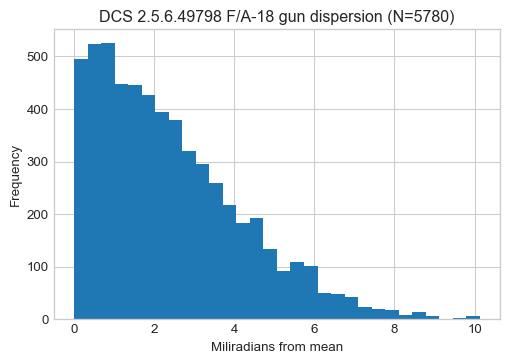

In [10]:
pl.style.use('seaborn-whitegrid')
pl.figure(dpi=96)
pl.hist(vg.angle(avg, np.array(initials), units='rad')*1000, bins=30)
pl.grid(True)
pl.title('DCS 2.5.6.49798 F/A-18 gun dispersion (N=5780)')
pl.xlabel('Miliradians from mean')
pl.ylabel('Frequency')
pl.savefig('dispersion.png')


In [14]:
import pandas


In [15]:
df = pandas.DataFrame(yz.T/vg.magnitude(avg)*1000, columns=['x', 'z'])
df_new = pandas.DataFrame(yz_new.T/vg.magnitude(avg)*1000, columns=['x', 'z'])

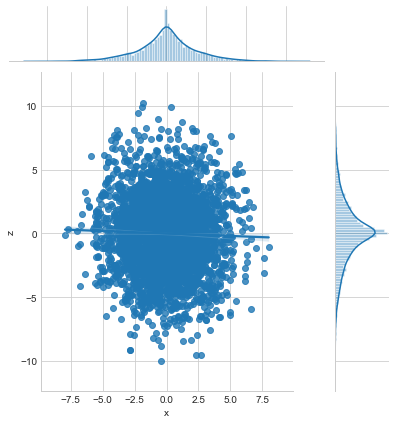

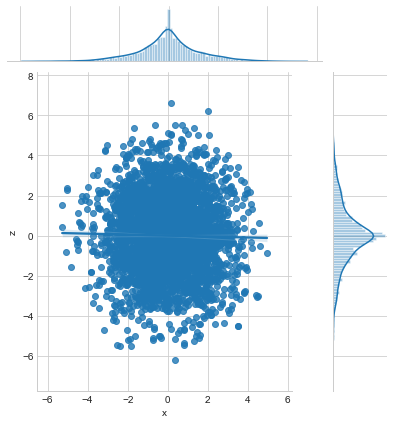

In [16]:
import seaborn as sns
sns.set_style("whitegrid")
#sns.set_style("dark")

jnt = sns.jointplot(x="x", y="z", data=df, kind='reg', marginal_kws=dict(bins=100));
jnt.ax_joint.set_aspect('equal')

jnt = sns.jointplot(x="x", y="z", data=df_new, kind='reg', marginal_kws=dict(bins=100));
jnt.ax_joint.set_aspect('equal')

(array([307.000, 301.000, 347.000, 300.000, 317.000, 280.000, 279.000,
        269.000, 259.000, 267.000, 245.000, 248.000, 212.000, 210.000,
        188.000, 179.000, 157.000, 153.000, 161.000, 119.000, 107.000,
        116.000, 97.000, 86.000, 76.000, 55.000, 60.000, 78.000, 49.000,
        43.000, 29.000, 34.000, 26.000, 19.000, 26.000, 6.000, 12.000,
        14.000, 9.000, 7.000, 13.000, 5.000, 3.000, 2.000, 1.000, 0.000,
        3.000, 3.000, 2.000, 1.000]),
 array([0.006, 0.213, 0.421, 0.629, 0.836, 1.044, 1.251, 1.459, 1.666,
        1.874, 2.081, 2.289, 2.497, 2.704, 2.912, 3.119, 3.327, 3.534,
        3.742, 3.949, 4.157, 4.365, 4.572, 4.780, 4.987, 5.195, 5.402,
        5.610, 5.817, 6.025, 6.233, 6.440, 6.648, 6.855, 7.063, 7.270,
        7.478, 7.685, 7.893, 8.101, 8.308, 8.516, 8.723, 8.931, 9.138,
        9.346, 9.553, 9.761, 9.969, 10.176, 10.384]),
 <a list of 50 Patch objects>)

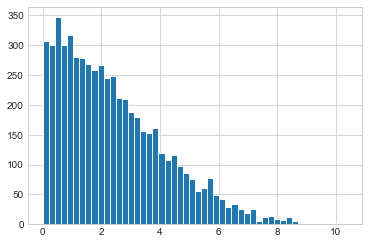

In [15]:
pl.hist(np.sqrt(df['x']**2+df['z']**2), bins=50)